I want to try out multiclass, and see if I get better results

In [1]:
# Import statements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix, roc_auc_score
from tensorflow.keras import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
%matplotlib inline

In [2]:
# helper function for one of our technical indicators
def calc_rsi(df, periods = 14, ema = True):
    """
    Returns a pd.Series with the relative strength index.
    """
    close_delta = df.adj_close.diff()

    # Make two series: one for lower closes and one for higher closes
    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)
    
    if ema == True:
        # Use exponential moving average
        ma_up = up.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
        ma_down = down.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
    else:
        # Use simple moving average
        ma_up = up.rolling(window = periods, adjust=False).mean()
        ma_down = down.rolling(window = periods, adjust=False).mean()
        
    rsi = ma_up / ma_down
    rsi = 100 - (100/(1 + rsi))
    return rsi

In [3]:
#defining our preprocessing
def read_data(filename):
    # read in the data
    data = pd.read_csv(filename)
    data = data.rename(str.lower, axis=1)
    data = data.rename(mapper={'adj close': 'adj_close'}, axis=1)
    data.date = pd.to_datetime(data.date)
    data = data.set_index('date')
    return data

def add_features(df):
    # accumulation/Distribution line
    mult = ((df.close - df.low) - (df.high - df.close)) / (df.high - df.low)
    MFVolume = mult * df.volume
    accum_dist_indicator = MFVolume.cumsum()
    ret_df = pd.concat([df, accum_dist_indicator], axis=1)
    ret_df = ret_df.rename(mapper={0:'accum_dist_indicator'}, axis=1)
    
    #MACD
    EMA_12 = df.adj_close.ewm(span=12, adjust=False).mean()
    EMA_26 = df.adj_close.ewm(span=26, adjust=False).mean()
    macd = EMA_12 - EMA_26
    signal = macd.ewm(span=9, adjust=False).mean()
    ret_df = pd.concat([ret_df, macd.rename('macd'), signal.rename('signal_macd')], axis=1)
    
    #RSI
    rsi = calc_rsi(df)
    ret_df = pd.concat([ret_df, rsi.rename('rsi')], axis=1)
    
    return ret_df

def series_to_supervised(data, n_in=1, n_out=1, col_names = [], indicies = [], preds = [], dropnan=True):
    '''
    Convert a time series to a supervised learning dataset
    Args:
        data -> time series to convert as a list or numpy array
        n_in -> number of lag observations as input (X)
        n_out -> number of observations as output (y)
        col_names -> names of the columns
        indicies -> list of the indicies
        preds -> list of column indicies to determine which variables to predict
        dropnan -> flag of whether to drop the rows with NaN
    Returns:
        Pandas DataFrame of series framed for supervised learning
    '''
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' % (col_names[j], i)) for j in range(n_vars)]
    # forecast sequence
    for i in range(0, n_out):
        cols.append(df[col_names[preds]].shift(-i))
        if i==0:
            names += [('%s(t)' % (col_names[j])) for j in preds]
        else:
            names += [('%s(t+%d)' % (col_names[j], i)) for j in preds]
    # putting it together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    agg.index = indicies
    if dropnan:
        agg.dropna(inplace=True)
    return agg

def scale(in_train, in_test, with_labels=False):
    '''
    Rescales the train and test sets
    Args:
        train -> numpy array of the training data
        test -> numpy array of the test data
        with_labels -> if set to true will cut off last column before scaling,
            reattached after scaling
    Returns:
        scaler -> the scaler object for transforming
        train_scaled -> a rescaled version of the train data
        test_scaled -> a rescaled version of the test data
    '''
    train = in_train
    test = in_test
    if with_labels:
        train_labels = train[:,-1]
        train = train[:,:-1]
        test_labels = test[:,-1]
        test = test[:,:-1]
    # scale train and test to [-1,1]
    scaler = MinMaxScaler(feature_range=(-1,1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    if with_labels:
        train_scaled.append(train_labels, axis=1)
        test_scaled.append(test_labels, axis=1)
    return scaler, train_scaled, test_scaled

def split_data(data, test_percent):
    '''
    Splits the data by percentage amount
    Returns: train, test
    '''
    split_val = int(len(data) * (1 - test_percent))
    train, test = data[:split_val], data[split_val:]
    return train, test

In [4]:
def class_separation(x):
    if x < -.05:
        return -2
    elif x < -.005:
        return -1
    elif x > .05:
        return 2
    elif x > .005:
        return 1
    else:
        return 0

def prep_data(filename, lookback=14):
    temp = np.array([0,1,2,-1,-2]).reshape(-1,1)
    # read in the data
    data = read_data(filename)
    # add technical indicators as features
    data = add_features(data)
    # frame as an RNN problem
    data = series_to_supervised(data, lookback, 5, data.columns, data.index, [4])
    # only keep the predictive columns I care about
    data = data.drop(data.columns[-5:-1], axis=1)
    labels = (data['adj_close(t+4)'] - data['adj_close(t-1)']) / data['adj_close(t-1)']
    labels = labels.apply(class_separation)
    data = data.drop(data.columns[-1], axis=1)
    data = pd.concat([data, labels.rename('labels')], axis=1)
    data_values = data.values
    train, test = split_data(data_values, .2)
    scaler, train_scaled, test_scaled = scale(train[:,:-1], test[:,:-1])
    ohe = OneHotEncoder(sparse=False).fit(temp)
    train_scaled = np.append(train_scaled, ohe.transform(train[:,-1].reshape((-1,1))), axis=1)
    test_scaled = np.append(test_scaled, ohe.transform(test[:,-1].reshape((-1,1))), axis=1)
    return scaler, train_scaled, test_scaled

In [5]:
def fit_lstm(train, batch_size, nb_epoch, neurons, label_size=5):
    X, y = train[:,:-label_size], train[:,-label_size:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    # prepare a model
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True, return_sequences=True))
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(5, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', 'AUC'])
    for i in range(nb_epoch):
        if not i % 10:
            print('%d/%d' % (i+1, nb_epoch), end='')
        else:
            print('.', end='')
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
        model.reset_states()
    print()
    return model

In [9]:
# get data
scaler, train, test = prep_data('../../data/SPY_1993-01-29_2022-08-17.csv')
# set parameters
batches = 16
neurons = 32
nb_epochs = 250
#trim the data and give it to the model
train_trimmed = train[len(train)%batches:]
test_trimmed = test[:-(len(test) % batches)] if len(test) % batches != 0 else test

In [81]:
lstm_model = fit_lstm(train_trimmed, batches, nb_epochs, neurons)

370/370 [==============================] - 4s 6ms/step - loss: 0.5836 - accuracy: 0.7476 - auc: 0.9544


370/370 [==============================] - 4s 7ms/step - loss: 0.5092 - accuracy: 0.7853 - auc: 0.9650



In [103]:
X, y = train_trimmed[:,:-5], train_trimmed[:,-5:]
X = X.reshape(X.shape[0], 1, X.shape[1])
y_pred = lstm_model.predict(X, batch_size=16)
y_pred[:5]

370/370 [==============================] - 5s 3ms/step


array([[1.2077448e-06, 2.2671573e-02, 9.3674004e-01, 4.0555473e-02,
        3.1706568e-05],
       [2.2110155e-06, 3.8984701e-02, 9.1802424e-01, 4.2956367e-02,
        3.2455700e-05],
       [1.4705214e-06, 6.8180434e-02, 8.4498042e-01, 8.6601466e-02,
        2.3623864e-04],
       [4.0483943e-07, 3.2408819e-02, 8.8286209e-01, 8.4544219e-02,
        1.8435836e-04],
       [5.5589896e-07, 3.2389209e-02, 7.5076908e-01, 2.1659625e-01,
        2.4494572e-04]], dtype=float32)

In [104]:
lstm_model.reset_states()
metrics = lstm_model.evaluate(X, y, batch_size=batches)

370/370 [==============================] - 6s 5ms/step - loss: 0.7436 - accuracy: 0.7073 - auc: 0.9347


In [105]:
print(lstm_model.metrics_names)
print(metrics)

['loss', 'accuracy', 'auc']
[0.7435736656188965, 0.7072635293006897, 0.9346805214881897]


In [123]:
lstm_model.reset_states()
lstm_model.predict(X, batch_size=16)
X, y = test_trimmed[:,:-5], test_trimmed[:,-5:]
X = X.reshape(X.shape[0], 1, X.shape[1])
metrics, something, sss = lstm_model.evaluate(X,y, batch_size=batches)

92/92 [==============================] - 2s 6ms/step - loss: 3.0207 - accuracy: 0.2833 - auc: 0.6445


In [108]:
print(lstm_model.metrics_names)
print(metrics)

['loss', 'accuracy', 'auc']
[3.1463370323181152, 0.2805706560611725, 0.6415072083473206]


Overfit pretty well, now time to experiment with different dropout rates

In [10]:
def fit_lstm(train, batch_size, nb_epoch, neurons, dropout=.2, label_size=5):
    X, y = train[:,:-label_size], train[:,-label_size:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    # prepare a model
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True, return_sequences=True, dropout=dropout))
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True, dropout=dropout))
    model.add(Dense(5, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.Precision(),
                                                                              tf.keras.metrics.Recall(),
                                                                              'AUC'])
    for i in range(nb_epoch):
        if not i % 10:
            print('%d/%d' % (i+1, nb_epoch), end='')
        else:
            print('.', end='')
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    print()
    return model

In [15]:
def experiment(repeats, train, test, dropout_rate):
    # paprameters
    batch_size = 64
    neurons = 32
    nb_epochs = 250
    prec_scores, recall_scores, auc_scores, losses = list(), list(), list(), list()
    for r in range(repeats):
        # fit the model
        train_trimmed = train[len(train)%batch_size:]
        lstm_model = fit_lstm(train_trimmed, batch_size, nb_epochs, neurons, dropout=dropout_rate)
        # forecast the training set to set state
        train_reshaped = train_trimmed[:,:-5].reshape(len(train_trimmed), 1, -1)
        lstm_model.predict(train_reshaped, batch_size=batch_size, verbose=0)
        # now forecast the test set
        test_trimmed = test[:-(len(test) % batch_size)] if (len(test)%batch_size) != 0 else test
        test_reshaped = test_trimmed[:,:-5].reshape(len(test_trimmed), 1, -1)
        loss, prec, rec, auc = lstm_model.evaluate(test_reshaped, test_trimmed[:,-5:], batch_size)
        print('%d) Test metrics - loss: %.3f, prec: %.3f, rec: %.3f, roc_auc: %.3f' %(r+1, loss, prec, rec, auc))
        prec_scores.append(prec)
        recall_scores.append(rec)
        auc_scores.append(auc)
        losses.append(loss)
    return losses, prec_scores, recall_scores, auc_scores

1/250.........11/250.........21/250.........31/250.........41/250.........51/250.........61/250.........71/250.........81/250.........91/250.........101/250.........111/250.........121/250.........131/250.........141/250.........151/250.........161/250.........171/250.........181/250.........191/250.........201/250.........211/250.........221/250.........231/250.........241/250.........
23/23 [==============================] - 1s 6ms/step - loss: 2.1500 - precision_4: 0.2656 - recall_4: 0.2262 - auc: 0.6768
1) Test metrics - loss: 2.150, prec: 0.266, rec: 0.226, roc_auc: 0.677
1/250.........11/250.........21/250.........31/250.........41/250.........51/250.........61/250.........71/250.........81/250.........91/250.........101/250.........111/250.........121/250.........131/250.........141/250.........151/250.........161/250.........171/250.........181/250.........191/250.........201/250.........211/250.........221/250.........231/250.........241/250.........
23/23 [===================

1/250.........11/250.........21/250.........31/250.........41/250.........51/250.........61/250.........71/250.........81/250.........91/250.........101/250.........111/250.........121/250.........131/250.........141/250.........151/250.........161/250.........171/250.........181/250.........191/250.........201/250.........211/250.........221/250.........231/250.........241/250.........
23/23 [==============================] - 1s 5ms/step - loss: 2.3217 - precision_18: 0.2716 - recall_18: 0.2242 - auc: 0.6657
15) Test metrics - loss: 2.322, prec: 0.272, rec: 0.224, roc_auc: 0.666
1/250.........11/250.........21/250.........31/250.........41/250.........51/250.........61/250.........71/250.........81/250.........91/250.........101/250.........111/250.........121/250.........131/250.........141/250.........151/250.........161/250.........171/250.........181/250.........191/250.........201/250.........211/250.........221/250.........231/250.........241/250.........
23/23 [================

1/250.........11/250.........21/250.........31/250.........41/250.........51/250.........61/250.........71/250.........81/250.........91/250.........101/250.........111/250.........121/250.........131/250.........141/250.........151/250.........161/250.........171/250.........181/250.........191/250.........201/250.........211/250.........221/250.........231/250.........241/250.........
23/23 [==============================] - 1s 6ms/step - loss: 2.0878 - precision_32: 0.2745 - recall_32: 0.2133 - auc: 0.6370
14) Test metrics - loss: 2.088, prec: 0.274, rec: 0.213, roc_auc: 0.637
1/250.........11/250.........21/250.........31/250.........41/250.........51/250.........61/250.........71/250.........81/250.........91/250.........101/250.........111/250.........121/250.........131/250.........141/250.........151/250.........161/250.........171/250.........181/250.........191/250.........201/250.........211/250.........221/250.........231/250.........241/250.........
23/23 [================

1/250.........11/250.........21/250.........31/250.........41/250.........51/250.........61/250.........71/250.........81/250.........91/250.........101/250.........111/250.........121/250.........131/250.........141/250.........151/250.........161/250.........171/250.........181/250.........191/250.........201/250.........211/250.........221/250.........231/250.........241/250.........
23/23 [==============================] - 1s 6ms/step - loss: 1.4005 - precision_46: 0.3674 - recall_46: 0.2052 - auc: 0.7508
13) Test metrics - loss: 1.400, prec: 0.367, rec: 0.205, roc_auc: 0.751
1/250.........11/250.........21/250.........31/250.........41/250.........51/250.........61/250.........71/250.........81/250.........91/250.........101/250.........111/250.........121/250.........131/250.........141/250.........151/250.........161/250.........171/250.........181/250.........191/250.........201/250.........211/250.........221/250.........231/250.........241/250.........
23/23 [================

1/250.........11/250.........21/250.........31/250.........41/250.........51/250.........61/250.........71/250.........81/250.........91/250.........101/250.........111/250.........121/250.........131/250.........141/250.........151/250.........161/250.........171/250.........181/250.........191/250.........201/250.........211/250.........221/250.........231/250.........241/250.........
23/23 [==============================] - 1s 5ms/step - loss: 1.4244 - precision_60: 0.3506 - recall_60: 0.0829 - auc: 0.7178
12) Test metrics - loss: 1.424, prec: 0.351, rec: 0.083, roc_auc: 0.718
1/250.........11/250.........21/250.........31/250.........41/250.........51/250.........61/250.........71/250.........81/250.........91/250.........101/250.........111/250.........121/250.........131/250.........141/250.........151/250.........161/250.........171/250.........181/250.........191/250.........201/250.........211/250.........221/250.........231/250.........241/250.........
23/23 [================

1/250.........11/250.........21/250.........31/250.........41/250.........51/250.........61/250.........71/250.........81/250.........91/250.........101/250.........111/250.........121/250.........131/250.........141/250.........151/250.........161/250.........171/250.........181/250.........191/250.........201/250.........211/250.........221/250.........231/250.........241/250.........
23/23 [==============================] - 1s 6ms/step - loss: 1.3120 - precision_74: 0.4186 - recall_74: 0.0611 - auc: 0.7364
11) Test metrics - loss: 1.312, prec: 0.419, rec: 0.061, roc_auc: 0.736
1/250.........11/250.........21/250.........31/250.........41/250.........51/250.........61/250.........71/250.........81/250.........91/250.........101/250.........111/250.........121/250.........131/250.........141/250.........151/250.........161/250.........171/250.........181/250.........191/250.........201/250.........211/250.........221/250.........231/250.........241/250.........
23/23 [================

AttributeError: 'int' object has no attribute 'boxplot'

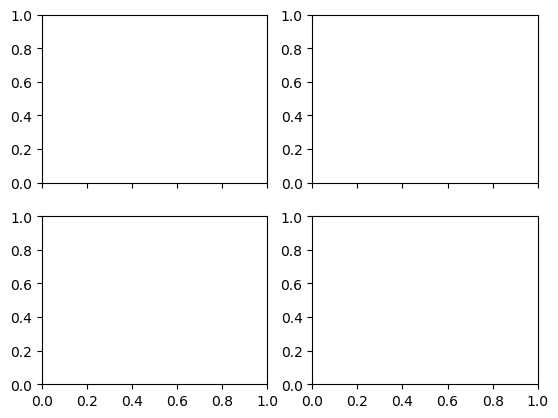

In [16]:
dropouts = [.05, .1, .2, .3, .5]
repeats = 15
losses, precisions, recalls, aucs = pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
for d in dropouts:
    losses[str(d)], precisions[str(d)], recalls[str(d)], aucs[str(d)] = experiment(repeats, train, test, d)
print(losses.describe())
print(precisions.describe())
print(recalls.describe())
print(aucs.describe())

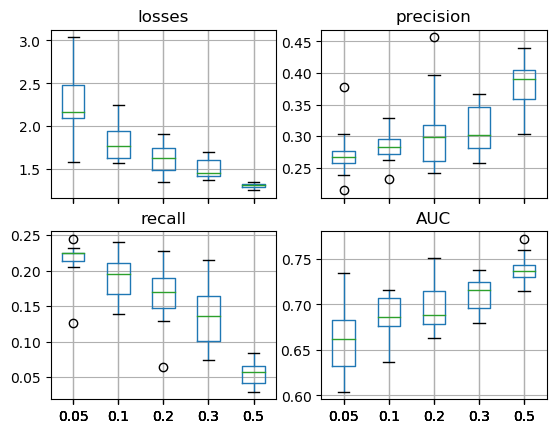

In [23]:
fig, ax = plt.subplots(2, 2, sharex=True)
losses.boxplot(ax=ax[0][0])
precisions.boxplot(ax=ax[0][1])
recalls.boxplot(ax=ax[1][0])
aucs.boxplot(ax=ax[1][1])
ax[0][0].set_title('losses')
ax[0][1].set_title('precision')
ax[1][0].set_title('recall')
ax[1][1].set_title('AUC')
plt.savefig('boxplot_dropouts.png')
plt.show()